In [55]:
# import relevant libraries
import osmnx as ox
import folium as fl
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

### 1. Extract Generators

In [56]:
# load & combine power plant data from osmnx (i.e. Overpass) for SN & BB
# power_stations_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':['plant','generator']})
# power_stations_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':['plant','generator']})

In [57]:
power_stations = gpd.GeoDataFrame(pd.concat([power_stations_sachsen, power_stations_brandenburg], ignore_index=True))
# print(power_stations_sachsen.columns.to_frame())
vars_to_keep = ['geometry',
                'generator:source',
                'generator:output:electricity',
                'generator:method', 
                'generator:type']


power_stations = power_stations[vars_to_keep]
power_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40600 entries, 0 to 40599
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   geometry                      40600 non-null  geometry
 1   generator:source              39655 non-null  object  
 2   generator:output:electricity  37393 non-null  object  
 3   generator:method              38390 non-null  object  
 4   generator:type                36077 non-null  object  
dtypes: geometry(1), object(4)
memory usage: 1.5+ MB


### 2. Extract Substations

In [58]:
# load & combine power substation data from osmnx
# substations_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':'substation'})
# substations_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':'substation'})

In [59]:
substations = gpd.GeoDataFrame(pd.concat([substations_sachsen, substations_brandenburg], ignore_index=True))
# print(substations.columns.to_frame())
vars_to_keep = ['geometry',
                'voltage',
                'frequency'] # just out of curiosity


substations = substations[vars_to_keep]
substations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8370 entries, 0 to 8369
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   8370 non-null   geometry
 1   voltage    1077 non-null   object  
 2   frequency  741 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 196.3+ KB


In [60]:
# get overview of voltage of values in voltage
print(substations['voltage'].value_counts())

voltage
110000           546
20000;400        152
20000            127
380000            30
10000;400         29
110000;15000      25
10000             19
15000             18
110000;20000      18
21000;400         17
30000;750         16
30000             12
20000;110000       9
220000             8
400                7
30000;15000        4
110000;30000       4
400;20000          4
220000;110000      3
63000              3
600                3
110000;31500       2
low                2
medium;low         2
110000;10000       2
380000;110000      2
20000;15000        2
21000              1
660_v_dc           1
30000;10000        1
110000;400         1
0                  1
medium;400         1
1028               1
1000               1
110000;33000       1
20                 1
11000              1
Name: count, dtype: int64


In [61]:
# drop rows where voltage is NaN
substations = substations[substations['voltage'].notna()]

# filter substations for voltage >= 110000V
substations_transmission = substations[substations['voltage'].apply(lambda x: any(int(v) >= 110000 for v in str(x).split(';') if v.isdigit()))]

In [62]:
substations_transmission.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   651 non-null    geometry
 1   voltage    651 non-null    object  
 2   frequency  422 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 20.3+ KB


### 3. Assign Bundesland Information

In [63]:
# load Länder polygons via osmnx nominatim (way faster than querying via osmnx / Overpass)

states = ["Brandenburg","Sachsen"]

gdf = ox.geocode_to_gdf([f"{s}, Germany" for s in states])
laender = gdf[["name","geometry"]]


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

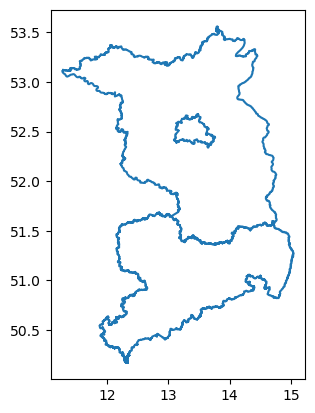

In [64]:
# quick check of länder geometries
laender.boundary.plot()
laender.crs

In [ ]:
# make a 'within' spatial join to get Bundesland for each substation
substations_transmission = gpd.sjoin(substations_transmission, laender, how="left", predicate='within')
substations_transmission.drop(columns=['index_right'], inplace=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   651 non-null    geometry
 1   voltage    651 non-null    object  
 2   frequency  422 non-null    object  
 3   name       651 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 25.4+ KB


In [66]:
substations_transmission.head()

,geometry,voltage,frequency,name
1318,"POLYGON ((12.36006 51.29549, 12.36041 51.2955,...",110000,NaN,Saxony
1322,"POLYGON ((12.37123 51.17663, 12.37129 51.17663...",110000,NaN,Saxony
1323,"POLYGON ((13.61047 51.09218, 13.60903 51.09184...",110000,50,Saxony
1324,"POLYGON ((12.26329 51.24467, 12.26367 51.24455...",110000,50,Saxony
1325,"POLYGON ((12.23262 51.29287, 12.23231 51.29284...",110000,50,Saxony


name
Brandenburg    405
Saxony         246
Name: count, dtype: int64


<Axes: >

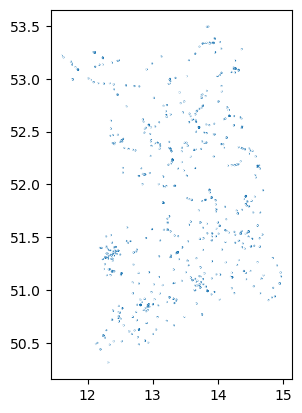

In [50]:
print(substations_transmission.value_counts('name'))
substations_transmission.boundary.plot()

### 4. Associate Generators to Substations

In [69]:
# set substations and generators to same crs, fitting Germany EPSG:25833) 
substations_transmission = substations_transmission.to_crs("EPSG:25833")
power_stations = power_stations.to_crs(substations_transmission.crs)



In [70]:
substations_transmission.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   651 non-null    geometry
 1   voltage    651 non-null    object  
 2   frequency  422 non-null    object  
 3   name       651 non-null    object  
dtypes: geometry(1), object(3)
memory usage: 25.4+ KB


In [71]:
substations_transmission.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Croatia; Denmark - offshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 34.79, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [78]:
# get the nearest substation for each power station
power_stations_with_substations = gpd.sjoin_nearest(power_stations, substations_transmission,
                            how="left", distance_col="dist")



In [82]:
power_stations_with_substations.head()

,geometry,generator:source,generator:output:electricity,generator:method,generator:type,index_right,voltage,frequency,name,dist
0,POINT (396443.993 5639269.346),wind,1.8 MW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,10459.341908
1,POINT (396010.786 5639776.856),wind,600 kW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,11023.764769
2,POINT (396066.235 5640136.06),wind,600 kW,wind_turbine,horizontal_axis,1495,110000,NaN,Saxony,11088.844679
3,POINT (400094.281 5657513.302),wind,1000 kW,wind_turbine,horizontal_axis,1323,110000,50,Saxony,4254.620483
4,POINT (361743.592 5661363.86),hydro,yes,run-of-the-river,NaN,1866,110000,50,Saxony,3643.135617


In [73]:
# for power stations and substations, give the value count of geometry types
print(power_stations['geometry'].geom_type.value_counts())
print(substations['geometry'].geom_type.value_counts())

Polygon         31033
Point            9498
MultiPolygon       58
LineString         11
Name: count, dtype: int64
Polygon    1012
Point        65
Name: count, dtype: int64


In [83]:
# take every 100th element to have a shorter df for the map
ps_plot = power_stations_with_substations[::100]

In [ ]:

if ps_plot.crs is None or ps_plot.crs.to_epsg() != 4326:
    ps_plot = ps_plot.to_crs(epsg=4326)

# representative point for all geometries
rep_points = ps_plot.geometry.apply(lambda g: g if g.geom_type == 'Point' else g.centroid)

# center map on data
center_lat = rep_points.y.mean()
center_lon = rep_points.x.mean()
m = fl.Map(location=[center_lat, center_lon], zoom_start=7)

for idx, row in ps_plot.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    if geom.geom_type == 'Point':
        lat, lon = geom.y, geom.x
    else:
        c = geom.centroid
        lat, lon = c.y, c.x
    popup = (f"Generator: {row.get('generator:method', 'n/a')}, \n"
             f"Source: {row.get('generator:source','n/a')}, \n"
             f"Output: {row.get('generator:output:electricity','n/a')}, \n"
             f"Nearest Substation: {row.get('index_right','n/a')}")
    fl.Marker(location=[lat, lon], popup=popup).add_to(m)

m.save("output/power_stations_map.html")


In [33]:
ps_plot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 406 entries, 0 to 40500
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   geometry                      406 non-null    geometry
 1   generator:source              397 non-null    object  
 2   generator:output:electricity  370 non-null    object  
 3   generator:method              385 non-null    object  
 4   generator:type                356 non-null    object  
 5   nearest_substation_idx        406 non-null    int64   
dtypes: geometry(1), int64(1), object(4)
memory usage: 19.2+ KB


<Axes: >

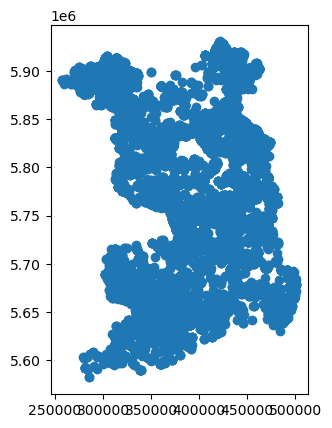

In [34]:
power_stations["centroid"] = power_stations.geometry.centroid
power_stations.centroid.plot()

### 5. Aggregate and Summarize